In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import viscid
from viscid.plot import vpyplot as vlt
import numpy as np
#import seaborn as sns
viscid.calculator.evaluator.enabled = True

matplotlib.rcParams['figure.figsize'] = (8, 8)

import scipy.constants as constants
mu0 = constants.mu_0
eps0 = constants.epsilon_0
mi = constants.proton_mass
me = constants.electron_mass
c = constants.c
e = constants.e
kB = constants.k
#matplotlib.style.use('ggplot')
#%config InlineBackend.figure_format = 'retina'

In [2]:
 #Point to directory with the data 
project_dir1="~/UNH/data_m100/"  # 100 mass ratio
project_dir4="~/UNH/data_m400/"  # 400 mass ratio

# Point to single .xdmf file within directory for sim data 
run1 = project_dir1+"/pfd.xdmf"  # mi/me = 100
run4 = project_dir4+"/pfd.xdmf"  # mi/me = 400



In [5]:
def make_plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(50,3*len(fldnames)))
    if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):
        # Hack around some inconsistencies with the field naming
        if run.endswith(".vpc"):
            map = {
                "bx_fc": "Magnetic Field X",
                "by_fc": "Magnetic Field Y",
                "bz_fc": "Magnetic Field Z",
                "jx": "Free Current Field X",
                "jy": "Free Current Field Y",
                
                "jz": "Free Current Field Z",
                "rho_nc": "Charge Density",
                "qn_nc_e": "Charge Density (ehydro)",
                "qn_nc_i": "Charge Density (Hhydro)",
                "jy_nc_e": "Current Density (ehydro) Y",
            }
        else:
            map = {
                "bx_fc": "hx_fc",
                "by_fc": "hy_fc",
                "bz_fc": "hz_fc",
                "qn_nc_e": "rho_nc_e",
                "qn_nc_i": "rho_nc_i",
            }
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        _fldname = map[fldname] if fldname in map else fldname
        mid_val = 0
        
        vlt.plot(vf[_fldname], ax=ax[i], **kwargs);
        #plt.scatter(371, 0, color = 'k')
        #plt.scatter(280,0,color = 'k')
        #vlt.plot(vf["psi"],style="contour",levels=300,colors='k', ax=ax[i], **kwargs);






# Convenient plotting fuction
def plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(10,3.5*len(fldnames)))
    #if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):

        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        
        vlt.plot(vf[fldname], ax=ax[i], **kwargs);
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)



#  Field interpolation (useful for getting fld value at a chosen coordinate)      
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]

               
# Gets E and B fields at a chosen coordinate
def Get_Fields(r):
    Ex, Ey, Ez = vf['ex_ec'], vf['ey_ec'], vf['ez_ec']
    Bx, By, Bz = vf['hx_fc'], vf['hy_fc'], vf['hz_fc']
    
    
    r = np.array([r[0],0,r[2]]) # Resets the y position to zero (2D sim so fields don't vary along y)
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B


pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]
# Right now this is specific to the mms_Kg211 run being used
def Em_Evolve(pts, run):
    t = 0
    vf = viscid.load_file(run, force_reload=True)
    var = np.zeros([31,2])
    while t<31:
        vf.activate_time(t)
        E,B = Get_Fields(np.array([pts[t],0,0]))
        var[t] = [t,E[1]] 
        
        t += 1
        
    return var


def make_vec(a,b,c):
    fld = viscid.empty(a.crds,nr_comps=3)
    
    fld['x'] = a
    fld['y'] = b
    fld['z'] = c
    
    fld = fld['y=0j']
    
    return fld



def Activate(run, time):
    vf = viscid.load_file(run, force_reload=True)
    t = time
    vf.activate_time(t)
    a = vf["hx_fc"]
    x,y,z = a.crds.get_crds_nc()
    dx,dy,dz = a.crds.get_dx()
        
    # E&B Fields
    Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
    Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
    E = make_vec(Ex,Ey,Ez)
    B = make_vec(Bx,By,Bz)

    B_mag = (Bx**2 + By**2 + Bz**2)**0.5
    E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

    EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag
    EPerp = E_mag - EPar

    # Current densities
    jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
    jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
    je = make_vec(jx_e,jy_e,jz_e)
    ji = make_vec(jx_i,jy_i,jz_i)

    J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5
    Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5

    JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag
    #JPerp = J_mag - JPar
    JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
    #JePerp = Je_mag - JePar

    # Velocities
    vex = jx_e / vf["rho_nc_e"]
    vey = jy_e / vf["rho_nc_e"]
    vez = jz_e / vf["rho_nc_e"]
    vix = jx_i / vf["rho_nc_i"]
    viy = jy_i / vf["rho_nc_i"]
    viz = jz_i / vf["rho_nc_i"]
    ve = make_vec(vex,vey,vez)
    vi = make_vec(vix,viy,viz)

    # Non-ideal E Fields
    Ex_prime = Ex  + vey*Bz - vez*By
    Ey_prime = Ey  + vez*Bx - vex*Bz
    Ez_prime = Ez  + vex*By - vey*Bx
    E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

    # Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
    uE = (Ex**2 + Ey**2 + Ez**2)/2
    uB = (Bx**2 + By**2 + Bz**2)/2
        # ## Maybe 

    # Number densities (related to charge density parameter)
    ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

    nq = "nq = rho_nc_e + rho_nc_i"

    # Temperatures
    # Divide by three?  or no?
    Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"]
    Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]

    Tee = make_vec(Tex, Tey, Tez) #  IMPORTANT NOTE: These are not really vector components...
    Tii = make_vec(Tix, Tiy, Tiz) #           .....they are diagonal terms in temp tensors

    Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
    Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3

    Te_Par = (Tex*(Bx**2) +Tey*(By**2) + Tez*(Bz**2)) / (Bx**2 + By**2 + Bz**2) 
    Ti_Par = (Tix*(Bx**2) +Tiy*(By**2) + Tiz*(Bz**2)) / (Bx**2 + By**2 + Bz**2) 
    Te_Perp = Te - Te_Par 
    Ti_Perp = Ti - Ti_Par 


    # Poynting Flux
    Sx = (Ey*Bz - Ez*By)#/mu0
    Sy = (Ez*Bx - Ex*Bz)#/mu0
    Sz = (Ex*By - Ey*Bx)#/mu0
    S = make_vec(Sx,Sy,Sz)


    # Kinetic Energy Flux
    #
    #
    #

    # J.E Contributions
    JEx = (jx_e + jx_i)*Ex
    JEy = (jy_e + jy_i)*Ey
    JEz = (jz_e + jz_i)*Ez
    JE = JEx + JEy + JEz

    JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez

    return E, B, S, ve, E_prime


In [4]:
pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]
pts4 = [783,783,783,783,783,783,783,783,783,780,780,780,780,780,780,780,778,776,774,775,775,775,775,775,775,775]

pts_rg = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,368,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]

pts_sm = [400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,399,399,399,399,399,399]


/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

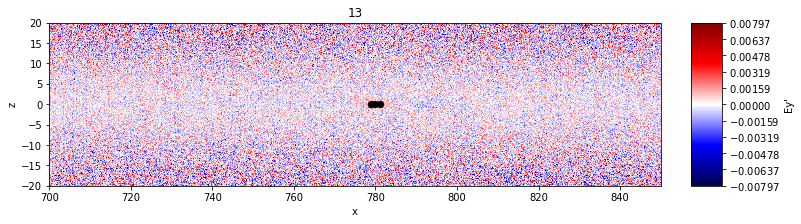

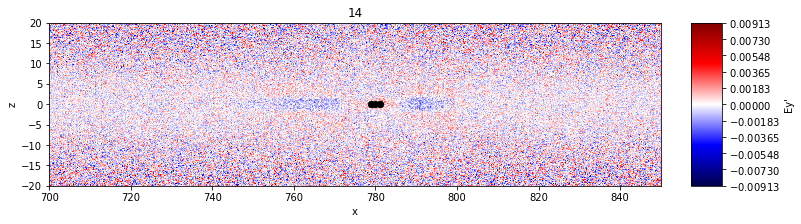

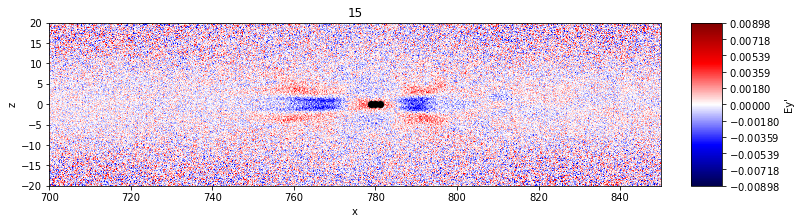

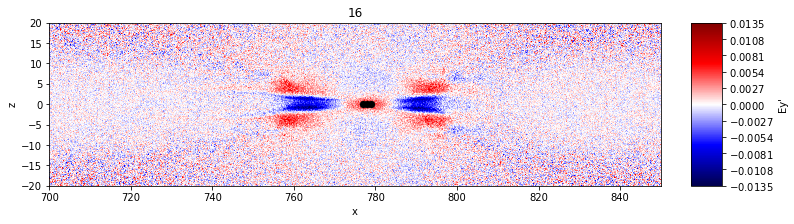

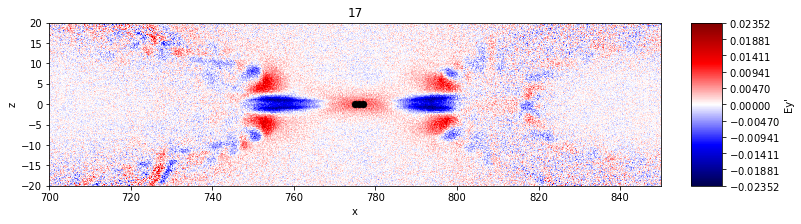

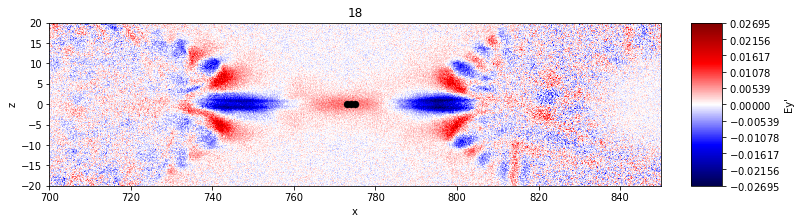

In [6]:

#Trillian Runs

run = run4

t = 13
selection = "x=700f:850f, z=-20f:20f"
EyPrime_e = "Ey' = ey_ec + (jz_nc_e * hx_fc)/rho_nc_e - (jx_nc_e * hz_fc)/rho_nc_e "
while t < 19:
    make_plot(t, run, [EyPrime_e],cmap = 'seismic',symmetric=True, selection = selection)
    plt.title(t)
    plt.scatter(pts4[t], 0, color = 'k', s = 50)
    plt.scatter(pts4[t]+1, 0, color = 'k', s = 50)
    plt.scatter(pts4[t]-1, 0, color = 'k', s = 50)

    t+=1

In [5]:
#Evaluates the terms in Poynting's theorem at different coordinates for each timestep so we can follow the EDR as the xline evolves

pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]

endrun1 = 30
endrun4 = 19

endrun = endrun1
pts = pts1
run = run1

def Evolve(pts, run):
    ERx = [None]*endrun
    dERx = [None]*endrun
    
    JdotE = [None]*endrun
    div_S = [None]*endrun
    du_dt = [None]*endrun
    
    for t in range(endrun):
        
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(t)
        a = vf["hx_fc"]
        x, y, z = a.crds.get_crds_nc()

        # E&B Fields
        Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
        Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]

        # Current densities
        jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
        jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
        
        # Velocities
        vex = jx_e / vf["rho_nc_e"]
        vey = jy_e / vf["rho_nc_e"]
        vez = jz_e / vf["rho_nc_e"]
        vix = jx_i / vf["rho_nc_i"]
        viy = jy_i / vf["rho_nc_i"]
        viz = jz_i / vf["rho_nc_i"]


        # Non-ideal E Fields
        Ex_prime = Ex  + vey*Bz - vez*By
        Ey_prime = Ey  + vez*Bx - vex*Bz
        Ez_prime = Ez  + vex*By - vey*Bx
        
        # Poynting Flux
        Sx = (Ey*Bz - Ez*By)#/mu0
        Sy = (Ez*Bx - Ex*Bz)#/mu0
        Sz = (Ex*By - Ey*Bx)#/mu0
        S = make_vec(Sx,Sy,Sz)
        
        # J.E Contributions
        JEx = (jx_e + jx_i)*Ex
        JEy = (jy_e + jy_i)*Ey
        JEz = (jz_e + jz_i)*Ez
        

        
        dx, dy, dz = a.crds.get_dx()
        
        # Poynting's Theorem Terms
        divS = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])  + (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0])
        JE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1])
        dudt = -JE - divS
        
        dsl = viscid.interp(divS, np.array([pts[t] - 1,0,0])) # measurement to the left
        dsr = viscid.interp(divS, np.array([pts[t] + 1,0,0])) # measurement to the right
        JEl = viscid.interp(JE, np.array([pts[t] - 1,0,0])) # measurement to the left
        JEr = viscid.interp(JE, np.array([pts[t] + 1,0,0])) # measurement to the right
        dul = viscid.interp(dudt, np.array([pts[t] - 1,0,0])) # measurement to the left
        dur = viscid.interp(dudt, np.array([pts[t] + 1,0,0])) # measurement to the right
        div_S[t] = (dsl+dsr+viscid.interp(divS, np.array([pts[t],0,0])))/3
        JdotE[t] = (JEl+JEr+viscid.interp(JE, np.array([pts[t],0,0])))/3
        du_dt[t] = (dul+dur+viscid.interp(dudt, np.array([pts[t],0,0])))/3
        

        lft = viscid.interp(Ey_prime, np.array([pts[t] - 1,0,0])) # measurement to the left
        rgt = viscid.interp(Ey_prime, np.array([pts[t] + 1,0,0])) # measurement to the right
        ERx[t] = (0*lft + 0*rgt + viscid.interp(Ey_prime, np.array([pts[t],0,0])))# / 3 # average 3 points value
    
    dERx[0] = 0
    dERx[endrun - 1] = 0
    #for t in range(endrun - 2):
        #dERx[t+1] = 0.5*(ERx[t+2] - ERx[t])
       #dERx[t+1] = 0.5*(ERx[t+1] + ERx[t+2]) - 0.5*(ERx[t+1] + ERx[t]) 
    return ERx, JdotE, div_S, du_dt #, dERx

#ERx, dERx = Evolve(pts, run)
ERx, JdotE, div_S, du_dt = Evolve(pts, run)


#JdotE_edg,Div_S_edg,du_edg = Poynts_Evolve(pts2)


In [6]:
help, du_dt

(Type help() for interactive help, or help(object) for help about object.,
 [0.0,
  1.0865270875607773e-06,
  8.59003072643342e-06,
  8.374273117321232e-06,
  -3.062862379010767e-05,
  1.4484703569905832e-05,
  -3.853445377899334e-06,
  2.7577219346615798e-06,
  -1.764154634050404e-05,
  -1.0493296334364762e-05,
  -1.39303495719408e-05,
  3.351754761145761e-05,
  1.4607094271923415e-06,
  1.373952788223202e-05,
  4.328454573017856e-05,
  -3.134033856137345e-05,
  -2.3266824427992105e-05,
  -4.273226659279317e-05,
  -2.119308919645846e-05,
  2.639249093287314e-05,
  1.0467066507165631e-05,
  8.303111220205514e-06,
  -2.394868351984769e-05,
  2.844681148417294e-07,
  -5.253175913821906e-06,
  1.495911055826582e-05,
  4.566906136460602e-05,
  -1.3187595565492908e-05,
  -1.2546869887349507e-05,
  2.9365333224025864e-05])

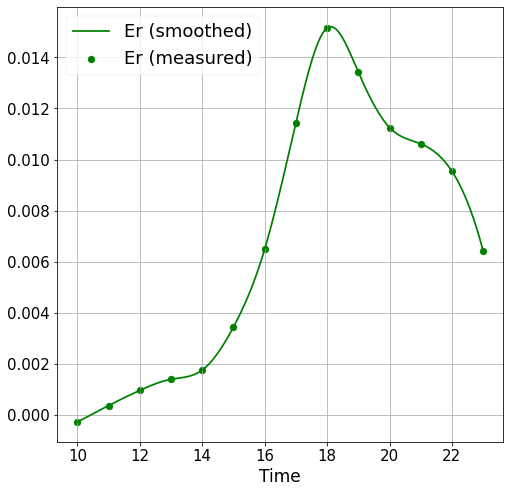

In [183]:
from scipy.interpolate import make_interp_spline
start = 10
stop  = 24
times = list(range(start,stop))
#plt.plot(times, np.abs(ERx[10:]), marker = 'o')
plt.figure(figsize=(8,8))
#plt.plot(times, ERx[start:stop], marker = 'o', color = 'g', label = 'Er')

# Interpolating in between points for smoother line
X_Y_Spline = make_interp_spline(times,ERx[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'g', label = 'Er (smoothed)')




plt.scatter(times, ERx[start:stop], marker = 'o', color = 'g', label = 'Er (measured)')
plt.yscale('linear')
plt.grid(True)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('E Rx', fontsize=17)
plt.legend(loc='upper left', prop={'size': 18})

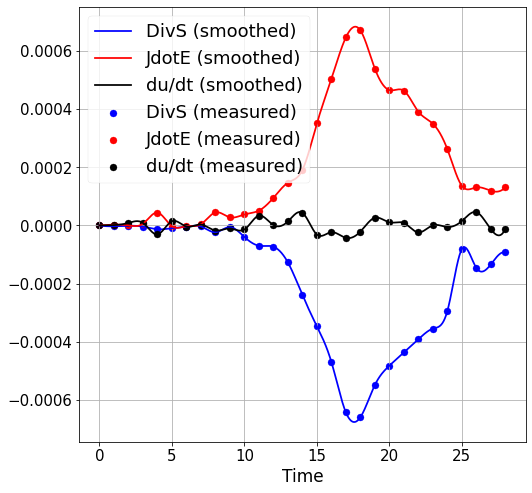

In [9]:
from scipy.interpolate import make_interp_spline
start = 0
stop  = 29
times = list(range(start,stop))
#plt.plot(times, np.abs(ERx[10:]), marker = 'o')
plt.figure(figsize=(8,8))
#plt.plot(times, dudt[start:stop], marker = 'o', color = 'g', label = 'Er')

# Interpolating in between points for smoother line
X_Y_Spline = make_interp_spline(times,div_S[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'b', label = 'DivS (smoothed)')

X_Y_Spline = make_interp_spline(times,JdotE[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'r', label = 'JdotE (smoothed)')

X_Y_Spline = make_interp_spline(times,du_dt[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'k', label = 'du/dt (smoothed)')




plt.scatter(times, div_S[start:stop], marker = 'o', color = 'b', label = 'DivS (measured)')
plt.scatter(times, JdotE[start:stop], marker = 'o', color = 'r', label = 'JdotE (measured)')
plt.scatter(times, du_dt[start:stop], marker = 'o', color = 'k', label = 'du/dt (measured)')


plt.yscale('linear')
plt.grid(True)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('E Rx', fontsize=17)
plt.legend(loc='upper left', prop={'size': 18})

In [ ]:
# Plot out-of-plane Efield over time
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)



start = 18
stop = 28
times = list(range(start,stop))

plt.plot(ERx[start:stop], marker = 'o', color = 'g')
plt.yscale('linear')
plt.axhline(y=0, color = 'k',linestyle = '--')
#plt.axvline(x=10-start, color = 'r',linestyle = '--')
#plt.axvline(x=13-start, color = 'r',linestyle = '--')
#plt.axvline(x=16-start, color = 'r',linestyle = '--')
#plt.axvline(x=18-start, color = 'r',linestyle = '--')
#plt.axvline(x=18, color = 'r',linestyle = '--')


#plt.ylabel('Em_prime')


plt.subplot(2,1,2)
#plt.plot(dERx[start:stop], marker = 'o',color = 'k')
#plt.axhline(y=0, color = 'k',linestyle = '--')
#plt.axvline(x=10-start, color = 'r',linestyle = '--')
#plt.axvline(x=13-start, color = 'r',linestyle = '--')
#plt.axvline(x=16-start, color = 'r',linestyle = '--')
#plt.axvline(x=18-start, color = 'r',linestyle = '--')
#plt.axvline(x=18, color = 'r',linestyle = '--')


#plt.ylabel('delta Em_prime')




plt.xlabel('t', fontsize = 15)

(<matplotlib.collections.QuadMesh at 0x7f51ce8d3040>,
 <matplotlib.colorbar.Colorbar at 0x7f50601927c0>)

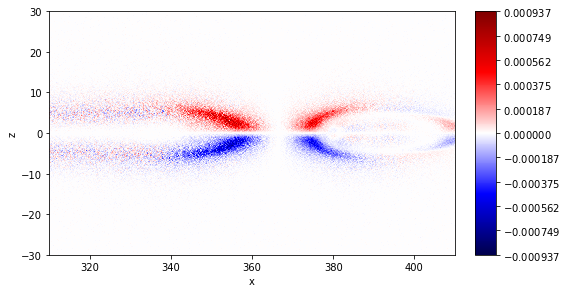

In [77]:

run = run1 #run1 or run4

vf = viscid.load_file(run, force_reload=True)

t = 16
vf.activate_time(t)
a = vf["hx_fc"]
x,y,z = a.crds.get_crds_nc()
dx,dy,dz = a.crds.get_dx()
    
# E&B Fields
Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
E = make_vec(Ex,Ey,Ez)
B = make_vec(Bx,By,Bz)

B_mag = (Bx**2 + By**2 + Bz**2)**0.5
E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag
EPerp = E_mag - EPar

# Current densities
jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
je = make_vec(jx_e,jy_e,jz_e)
ji = make_vec(jx_i,jy_i,jz_i)

J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5
Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5

JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag
#JPerp = J_mag - JPar
JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
#JePerp = Je_mag - JePar

# Velocities
vex = jx_e / vf["rho_nc_e"]
vey = jy_e / vf["rho_nc_e"]
vez = jz_e / vf["rho_nc_e"]
vix = jx_i / vf["rho_nc_i"]
viy = jy_i / vf["rho_nc_i"]
viz = jz_i / vf["rho_nc_i"]
ve = make_vec(vex,vey,vez)
vi = make_vec(vix,viy,viz)

# Non-ideal E Fields
Ex_prime = Ex  + vey*Bz - vez*By
Ey_prime = Ey  + vez*Bx - vex*Bz
Ez_prime = Ez  + vex*By - vey*Bx
E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

JE_prime = (je['x']+ji['x'])*E_prime['x'] + (je['y']+ji['y'])*E_prime['y'] + (je['z']+ji['z'])*E_prime['z'] 
#JE_prime = (je['x'])*E_prime['x'] + (je['y'])*E_prime['y'] + (je['z'])*E_prime['z'] 

# Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
uE = (Ex**2 + Ey**2 + Ez**2)/2
uB = (Bx**2 + By**2 + Bz**2)/2
    # ## Maybe 

# Number densities (related to charge density parameter)
ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

nq = "nq = rho_nc_e + rho_nc_i"

# Temperatures
# Divide by three?  or no?
Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"]
Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]

Tee = make_vec(Tex, Tey, Tez) #  IMPORTANT NOTE: These are not really vector components...
Tii = make_vec(Tix, Tiy, Tiz) #           .....they are diagonal terms in temp tensors

Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3

#Careful when calculating T_Perp.  You'll get negative vals if the factor of 1/3 is only on Te

Te_Par = (Tex*np.abs(Bx) +Tey*np.abs(By) + Tez*np.abs(Bz)) / 3*B_mag 
Te_Perp = Te - Te_Par 

Te_ParPerp = Te_Par/Te_Perp - 1


# Poynting Flux
Sx = (Ey*Bz - Ez*By)/mu0
Sy = (Ez*Bx - Ex*Bz)/mu0
Sz = (Ex*By - Ey*Bx)/mu0
S = make_vec(Sx,Sy,Sz)




# Kinetic Energy Flux
#
#
 #

 # J.E Contributions
JEx = (jx_e + jx_i)*Ex
JEy = (jy_e + jy_i)*Ey
JEz = (jz_e + jz_i)*Ez
JE = JEx + JEy + JEz

JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez



  #Poynting's Theorem Terms
divS = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])  + (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0])
JE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1])
#JE_alt = JEx + JEy + JEz
dudt = -JE - divS



vlt.plot(E['x']*B['y'],cmap = "seismic", symmetric=True, cbarlabel = " ", selection ="x=310f:410f, z=-30f:30f ")


/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')


KeyboardInterrupt: 

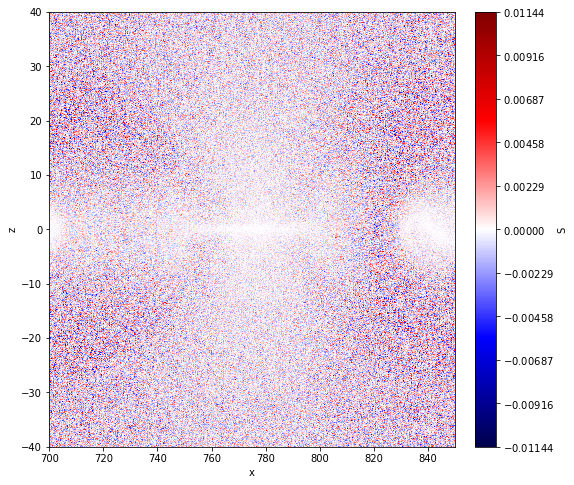

In [6]:

viscid.calculator.evaluator.enabled = True
#v = S['v']
#speed = viscid.magnitude(v)
#lw = 4 * speed / speed.max()


#fld = fld['y=0j']

#vlt.plot(E_prime['x'], cmap = "seismic", symmetric = "True",cbarlabel="S")
vlt.plot(dudt, cmap = "seismic", symmetric = "True",cbarlabel="S")

plt.xlim(700,850)
plt.ylim(-40,40)


vlt.streamplot(S, arrowsize=2, density=20, color='k')

plt.xlim(700,850)
plt.ylim(-40,40)

vlt.show()

{'left': 0.05776041666666667,
 'right': 0.9513406032986111,
 'top': 0.9925,
 'bottom': 0.0075000000000000015,
 'hspace': 0.2,
 'wspace': 0.2}

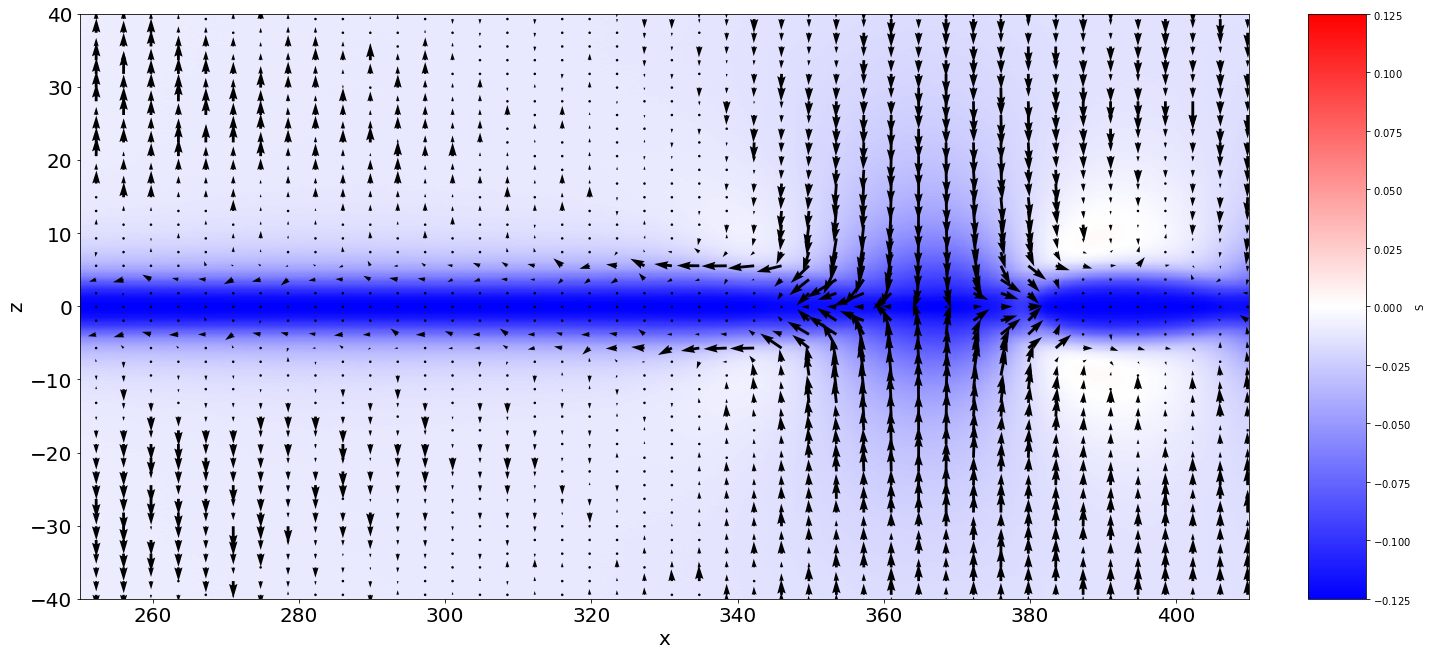

In [78]:
# Vector Plotting

plt.figure(figsize=(20, 20))
cut = 'x=::6, z=::3'
step = 4

vlt.plot(uB - 0.5*0.25, cmap = "bwr", symmetric = "True",cbarlabel="S")
_S_ = vlt.plot2d_quiver(S[cut],step = step ,scale = 10*max(S), linewidth=5000, color = 'k')
#_E_ = vlt.plot2d_quiver(E[cut],step = step ,scale = 10*max(E), linewidth=50, color = 'r')
#_B_ = vlt.plot2d_quiver(B[cut],step = step ,scale = 30*max(B), linewidth=50, color = 'b')

plt.xlim(250,410)
plt.ylim(-40,40)
fnt = 20
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.xlabel('x', fontsize=fnt)
plt.ylabel('z', fontsize=fnt)
vlt.auto_adjust_subplots()

In [54]:
np.max(B)
np.max(E)

0.04669768363237381

In [ ]:
# Vector Plotting

plt.figure(figsize=(10, 10))


vlt.plot(E_prime['y'], cmap = "seismic", symmetric = "True",cbarlabel="S")
Q = vlt.plot2d_quiver(S['x=::8, z=::4'],step = 2 ,scale = 30000, linewidth=500)
plt.xlim(310,400)
plt.ylim(-25,25)
fnt = 20
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
plt.xlabel('x', fontsize=fnt)
plt.ylabel('z', fontsize=fnt)
vlt.auto_adjust_subplots()

In [72]:
#fig, ax = plt.subplots(3,1,figsize=(20,20))

#vlt.plot(S['x'], ax = ax[0],cmap = "seismic", symmetric = "True",cbarlabel="Ey_prime", selection = "x=700f:850f, z=-40f:40f")
#vlt.plot(S['y'], ax = ax[1],cmap = "seismic", symmetric = "True",cbarlabel="Ey_prime", selection = "x=700f:850f, z=-40f:40f")
#vlt.plot(S['z'], ax = ax[2],cmap = "seismic", symmetric = "True",cbarlabel="Ey_prime", selection = "x=700f:850f, z=-40f:40f")

In [6]:
run = run1
E12, B12, S12, ve12, E12_prime = Activate(run,12)
E13, B13, S13, ve13, E13_prime = Activate(run,13)
E14, B14, S14, ve14, E14_prime = Activate(run,14)
E15, B15, S15, ve15, E15_prime = Activate(run,15)
E16, B16, S16, ve16, E16_prime = Activate(run,16)
E17, B17, S17, ve17, E17_prime = Activate(run,17)
E18, B18, S18, ve18, E18_prime = Activate(run,18)
E19, B19, S19, ve19, E19_prime = Activate(run,19)
E20, B20, S20, ve20, E20_prime = Activate(run,20)

/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')


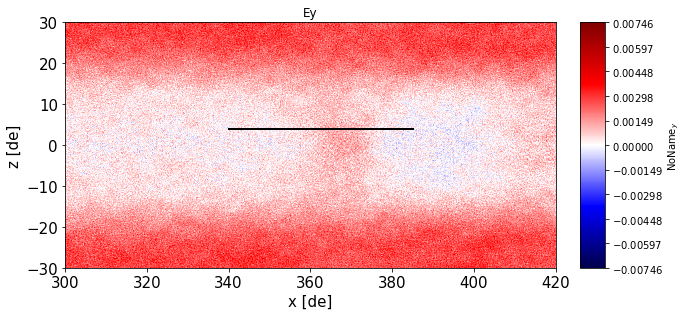

In [9]:
# Make 1D cuts to look at data along cut
# This cell makes 2 lines: a horizontal line from pt0 to pt1 and a vert line from pt2 to pt3
# an idea is to use this to study parameters along the inflow and outflow axes intersecting at the z-point

pt0 = (340, 0, 4) # x,y,z coords for beginning and end of a line in domain 
pt1 = (385, 0, 4)


pt2 = (pts1[t], 0, -60) # x,y,z coords for beginning and end of a line in domain (using pts#[t] keeps the vert line intersecting the center of x-point based on pre-defined pts)
pt3 = (pts1[t], 0, 60)
npts = 1000         # number of measurements along line between pt0 and pt1

lin_h = np.linspace(pt0[0], pt1[0], npts)
lin_v = np.linspace(pt2[2], pt3[2], npts)

seeds_h = viscid.seed.Line(pt0, pt1, npts)
seeds_v = viscid.seed.Line(pt2, pt3, npts)

seed_pts_v = seeds_v.get_points()
seed_pts_h = seeds_h.get_points()


fnt = 15 #axis fontsizes


# Make colorplot
plt.figure(figsize=(15,4.5))
plt.subplot(1,1,1)
vlt.plot(E['y'], cmap = "seismic", symmetric = True, title = 'Ey')
plt.axis("image")
plt.xlim(300,420)
plt.ylim(-30,30)
plt.xlabel("x [de]", fontsize=fnt)
plt.ylabel("z [de]", fontsize=fnt)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)




plt.plot(seed_pts_h[0,:], seed_pts_h[2,:], color = 'k', lw = 2)
#plt.plot(seed_pts_v[0,:], seed_pts_v[2,:], color = 'k')





vlt.tighten() #No idea what this does

In [53]:
# For plotting same variable over same cut for multiple timesteps (requires defining seperate fields for all timesteps)

#flds = [E12,E13,E14,E15,E16,E17,E18]
#flds_ = []
#fld_labs = ["12", "13", "14", "15", "16","17","18"]
#colors = ["k", "b", "c", "lightseagreen","g", 'orangered', 'r']

#for i in range(7):
#    flds_.append(viscid.interp_trilin(flds[i], seeds_h))

#fig, ax = plt.subplots(1,1,figsize=(10,10))

#for i in range(len(flds)):
#    plt.plot(lin_h, flds_[i]['y'], label = fld_labs[i], color = colors[i])
    


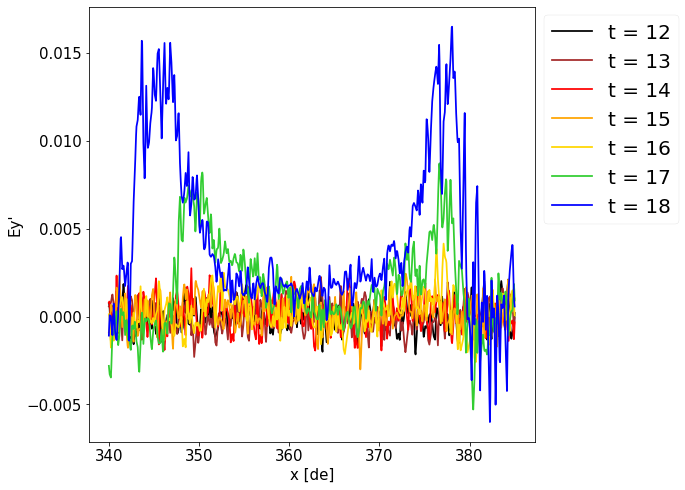

In [13]:
flds = [S12, S13, S14, S15, S16, S17, S18, S19, S20]
Bflds = [B12, B13, B14, B15, B16, B17, B18, B19, B20]
Eflds = [E12, E13, E14, E15, E16, E17, E18, E19, E20]
vflds = [ve12,ve13, ve14, ve15, ve16, ve17, ve18, ve19, ve20]
Epflds = [E12_prime, E13_prime, E14_prime, E15_prime, E16_prime, E17_prime, E18_prime, E19_prime, E20_prime]


labels = ['t = 12', 't = 13', 't = 14', 't = 15', 't = 16', 't = 17', 't = 18', 't = 19', 't = 20'] 
fldv = []
fldh = []
colors=['k', 'brown', 'red', 'orange', 'gold', 'limegreen', 'blue', 'c', 'magenta']




#plt.plot(lin_h, viscid.interp_trilin(B12['z'], seeds_h))
#plt.plot(lin_h, viscid.interp_trilin(B13['z'], seeds_h))

i=0
while i<len(flds)-2:
    plt.plot(lin_h, viscid.interp_trilin(Epflds[i]['y'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(-Eflds[i]['y']*Bflds[i]['x'], seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(vflds[i]['x']*Bflds[i]['z'], seeds_h), color = colors[i], label = labels[i] )

    i+=1
    
#plt.axhline(y = 1, color = 'k', linestyle = '--')#, label = 'upstream B0')
#plt.axhline(y = -1, color = 'k', linestyle = '--')#, label = 'upstream B0')

#plt.axvline(x = pts1[18], color = 'k', linestyle = 'dotted', lw = 2)#, label = 'upstream B0')

plt.xlabel("x [de]", fontsize = 15)
plt.ylabel("Ey'",fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(prop={'size': 20},loc=(1.02,0.5))

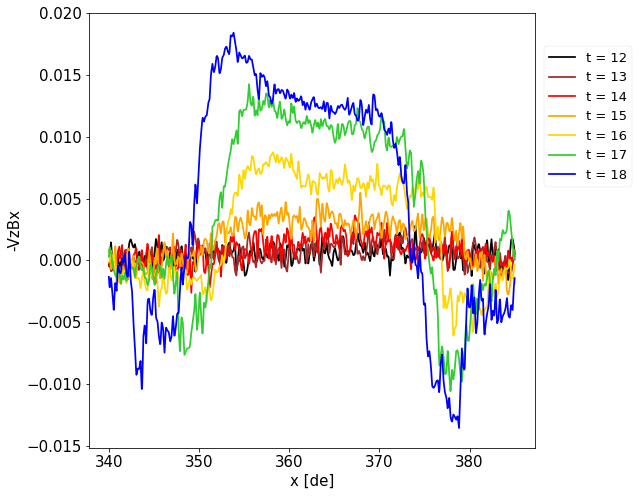

In [149]:
i=0
while i<len(flds)-2:
    #plt.plot(lin_h, viscid.interp_trilin(flds[i]['z']/0.5, seeds_h), color = colors[i], label = labels[i] )
    #plt.plot(lin_h, viscid.interp_trilin(Eflds[i]['y'], seeds_h), color = colors[i], label = labels[i] )
    plt.plot(lin_h, viscid.interp_trilin(-vflds[i]['z']*Bflds[i]['x'], seeds_h), color = colors[i], label = labels[i] )

    i+=1
    
#plt.axhline(y = 1, color = 'k', linestyle = '--')#, label = 'upstream B0')
#plt.axhline(y = -1, color = 'k', linestyle = '--')#, label = 'upstream B0')

#plt.axvline(x = pts1[18], color = 'k', linestyle = 'dotted', lw = 2)#, label = 'upstream B0')

plt.xlabel("x [de]", fontsize = 15)
plt.ylabel("-VzBx",fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(prop={'size': 13},loc=(1.02,0.6))

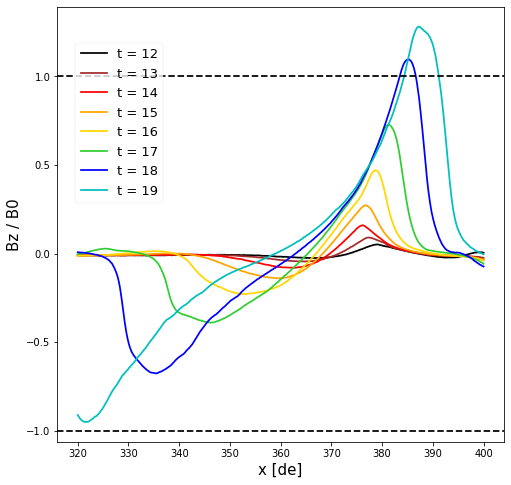

In [199]:
flds = [B12, B13, B14, B15, B16, B17, B18, B19, B20]

labels = ['t = 12', 't = 13', 't = 14', 't = 15', 't = 16', 't = 17', 't = 18', 't = 19', 't = 20'] 
fldv = []
fldh = []
colors=['k', 'brown', 'red', 'orange', 'gold', 'limegreen', 'blue', 'c', 'magenta']


fld = B12['z']


fld_label = "Bz"
n = 1


#plt.plot(lin_h, viscid.interp_trilin(B12['z'], seeds_h))
#plt.plot(lin_h, viscid.interp_trilin(B13['z'], seeds_h))

i=0
while i<len(flds)-1:
    plt.plot(lin_h, viscid.interp_trilin(flds[i]['z']/0.5, seeds_h), color = colors[i], label = labels[i] )
    i+=1
    
plt.axhline(y = 1, color = 'k', linestyle = '--')#, label = 'upstream B0')
plt.axhline(y = -1, color = 'k', linestyle = '--')#, label = 'upstream B0')

#plt.axvline(x = pts1[18], color = 'k', linestyle = 'dotted', lw = 2)#, label = 'upstream B0')

plt.xlabel("x [de]", fontsize = 15)
plt.ylabel("Bz / B0",fontsize = 15)

plt.legend(prop={'size': 13},loc=(0.04,0.55))

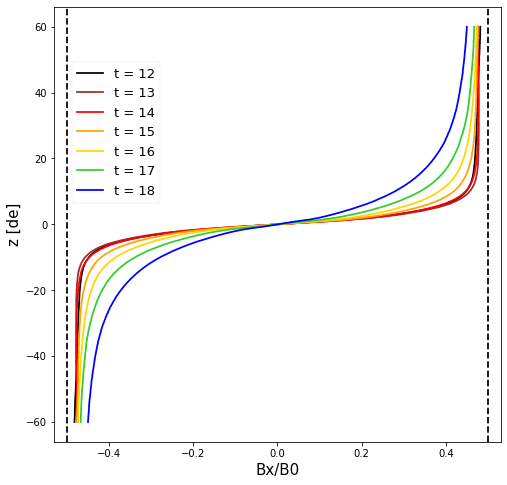

In [166]:
i=0
while i<len(flds):
    plt.plot(viscid.interp_trilin(flds[i]['x'], seeds_v), lin_v, color = colors[i], label = labels[i] )
    i+=1
    
plt.axvline(x = 0.5, color = 'k', linestyle = '--')#, label = 'upstream B0')
plt.axvline(x = -0.5, color = 'k', linestyle = '--')#, label = 'upstream B0')

#plt.axvline(x = pts1[18], color = 'k', linestyle = 'dotted', lw = 2)#, label = 'upstream B0')

plt.xlabel("Bx/B0", fontsize = 15)
plt.ylabel("z [de]",fontsize = 15)

plt.legend(prop={'size': 13},loc=(0.04,0.55))

Text(0, 0.5, 'Bz')

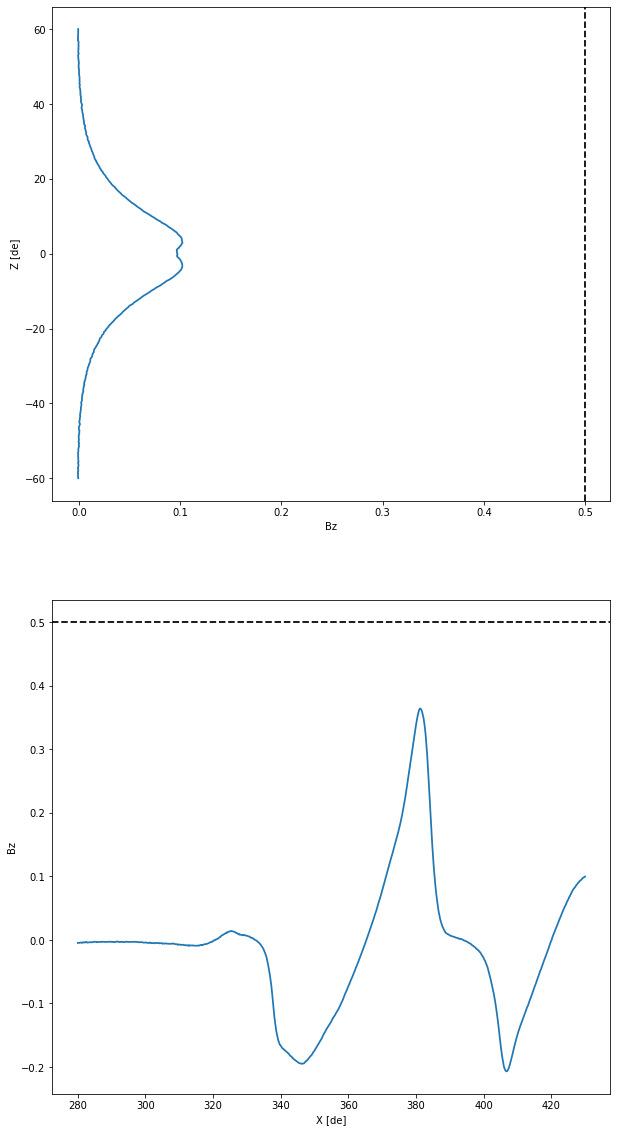

In [154]:
# Plots fld along vertical and horizontal line traced above

fld = B['z']
fld_v = viscid.interp_trilin(fld, seeds_v)
fld_h = viscid.interp_trilin(fld, seeds_h)

fld_label = "Bz"
n = 2
fig, ax = plt.subplots(n,1,figsize=(10,n*10))

ax[0].plot(fld_v, lin_v)
ax[0].axvline(x=0.5, color='k', linestyle='--')
ax[0].set_xlabel(fld_label)
ax[0].set_ylabel("Z [de]")

ax[1].plot(lin_h, fld_h)
ax[1].axhline(y=0.5, color='k', linestyle='--')
ax[1].set_xlabel("X [de]")
ax[1].set_ylabel(fld_label)





Text(0.5, 0, 'Tracing distance')

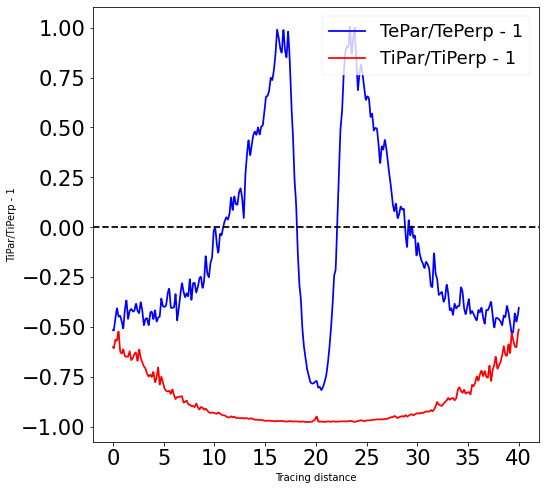

In [149]:
# Make plot of fld value along line
plt.subplot(1,1,1)
vlt.plot(viscid.interp_trilin(Te_Par/Te_Perp - 1, seeds), color = 'b', label = 'TePar/TePerp - 1') # Links coordinate of line to value of fld at that coordinate
vlt.plot(viscid.interp_trilin(Ti_Par/Ti_Perp - 1, seeds), color = 'r',label = 'TiPar/TiPerp - 1')
plt.axhline(y=0, color='k', linestyle='--')# Links coordinate of line to value of fld at that coordinate
plt.legend(prop={'size': 18})
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.xlabel("Tracing distance")
